## Mini Design Project

In [3]:
import math
import numpy as np
import random
from bayesian_optimization import BayesianOptimization
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator
from scipy.signal import savgol_filter

In [4]:
Tw = 50
mw = 154111.11/(4180000*(Tw-25)) #m3/s, Cp = 4184000 J/m3-K, Q in J/s
print(mw)

0.0014747474641148325


### 1) Double Pipe Heat Exchanger


In [5]:
# Heat Exchanger CAPEX
def h_i(mw): 
    # mw in m3/s, density = 981 kg/m3, viscosity = 1e-3 Pa-s, diameter = 0.0079m
    V = mw/(math.pi*(0.00395**2))
    Re = (0.0079*V*981)/0.001
    Nu = 0.0216*Re**0.853
    hi = (Nu*0.6)/0.0079
    return hi #W/m2-K

def h_o():
    # mv = 0.000228 m3/s, density_liquid = 755 kg/m3, density_vapour = 1.96 kg/m3, viscosity_Liquid = 0.00407 Pa-s, diameter = 0.0079m, kL = 0.13 W/(m-K)
    V_vapour = 0.000228/(math.pi*(0.00475**2))
    Re_Vapour = (V_vapour*0.0001)/5.59*10**-7 # Re film not normal Re
    ho = 0.0077*(((755*9.81*(755-1.96)*0.13**3)/0.0006**2)**1/3)*Re_Vapour**0.4
    return ho #W/m2-K

def Delta_T(Tw):
    dT1 = 84.26 - Tw # hot_in - cold_out
    dT2 = 80.81 - 25 # hot_out - cold_in
    Final_T = (dT1 - dT2) / math.log(dT1 / dT2)
    return Final_T #Kelvin

def U_o(hi,ho):
    num = (1/(math.pi*(0.0095)*1.05))
    denom = (1/(hi*math.pi*(0.0079*1.05)))+(1/((ho*math.pi*(0.0095)*1.05)))
    U = num/denom
    return U #W/m2-K

In [6]:
# Heat Exchanger CAPEX
hi = h_i(mw)
ho = h_o()
Uo = U_o(hi,ho)
HE_Area = 154111.11/(Uo*Delta_T(Tw))
print(f"Heat exchanger area:{HE_Area} m2")
Number_of_tubes = HE_Area/(math.pi*0.0079*2.00)
print(f"Number of tubes of 2.00 m length:{Number_of_tubes}")

Heat exchanger area:1.3190758814099424 m2
Number of tubes of 2.00 m length:26.574360359454563


### 2) Cooling Tower

In [7]:
# Cooling Tower Packing CAPEX
def Gl (mw):
    # to change mw from m3/s to kg/s
    mw = mw * 1000
    Mass_flux_liquid = mw/5 
    return Mass_flux_liquid # kg/m2-s

def H_or_Y (tg, RH):
    # tg in degree C, RH in %
    P_sat = math.exp(11.9648-(3984.92/((tg+273.15)-39.724)))
    Partial_P = P_sat*(RH/100)
    Y = (Partial_P/(1.013-Partial_P))*(18.01528/28.97)
    H = ((1005+1884*Y)*tg+2502300*Y)/1000
    return H,Y

def Mass_flowrate_air(Q, Hair_out, Hair_in):
    """
    Compute air mass flowrate [kg/s] from heat duty and air-side enthalpy rise.

    Q         : heat duty [W]
    Hair_out  : outlet air enthalpy [kJ/kg dry air]
    Hair_in   : inlet air enthalpy  [kJ/kg dry air]
    """
    m_air = Q / ((Hair_out - Hair_in) * 1000.0)  # 1000 converts kJ/kg to J/kg
    return m_air  # kg/s


def Gg(m_air):
    Mass_flux_gas = m_air/5
    return Mass_flux_gas # kg/m2-s


# Air Blower CAPEX (Just use Mass_flowrate_air)

# Water Replenishment OPEX
def water_evaporation(m_air, Yin, Yout):
    m_evap = m_air * (Yout - Yin)
    return m_evap # kg/s


# Air Blower OPEX

def Airblower_power(m_air, 
                    delta_p=400,     # Pa, heuristic pressure 
                    rho_air=1.15,    # kg/m3
                    eta_fan=0.75,    # blower efficiency (75%)
                    eta_motor=0.92   # motor efficiency (92%)
                   ):
    Q = m_air/rho_air
    P_air = delta_p*Q
    P_shaft = P_air/eta_fan
    P_elec = P_shaft/eta_motor
    P_elec_kw = (P_elec/1000.0)
    return P_elec_kw # kWh


In [8]:
#Cooling Tower CAPEX
Q = 154111.11 
Hair_out = H_or_Y(22, 100)[0]   # outlet air enthalpy [kJ/kg dry air]
Hair_in  = H_or_Y(24, 82)[0]    # inlet air enthalpy  [kJ/kg dry air]
m_air = Mass_flowrate_air(Q, Hair_out, Hair_in)

HTU = 0.480241* Gg(m_air) ** 0.216022 * Gl(mw) ** -0.667816
NTU = 1.5/HTU
Cooling_tower_packing = HTU * NTU * 1.5
print(f"HTU:{HTU}")
print(f"NTU:{NTU}")
print(f"Cooling tower packing:{Cooling_tower_packing}m3")

#Cooling Tower OPEX
Yin = H_or_Y (24,82)[1]
Yout = H_or_Y (22,100)[1]
Water_To_Be_Replenished = water_evaporation(m_air, Yin, Yout)
print(f"Water to be replenished:{Water_To_Be_Replenished} kg/s")  # When checked apporximately 10%

Air_Electricity = Airblower_power(m_air)
print(f"Air Electricity:{Air_Electricity} kWh")


HTU:2.208419125445716
NTU:0.6792188958684466
Cooling tower packing:2.2499999999999996m3
Water to be replenished:0.16951600583087822 kg/s
Air Electricity:67.55079959405174 kWh


### 3) Pumps

In [9]:
def pump_head_curve(mw_split, Impeller_speed):
    PUMP_CURVES = {
    2519: (-2e6, -342.73, 11.897),
    2629: (-2e6, -172.55, 12.932),
    2757: (-2e6, -409.79, 14.242),
    2883: (-2e6, -626.25, 15.883),
    3003: (-2e6, -689.19, 17.221)}
    a, b, c = PUMP_CURVES[Impeller_speed]
    H = a * (mw_split ** 2) + b * mw_split + c 
    return H

def pump_eff_curve(mw_split, Impeller_speed):
    EFFICIENCY_CURVES = {
    2519: (-3e7, 78760, 9.9884),
    2629: (-3e7, 79351, 9.7716),
    2757: (-3e7, 74369, 9.6288),
    2883: (-3e7, 68654, 12.422),
    3003: (-2e7, 65655, 12.063)}
    a, b, c = EFFICIENCY_CURVES[Impeller_speed]
    n = a * (mw_split ** 2) + b * mw_split + c 
    return n

def optimise_pumps_configuration(mw, 
                   Impeller_speed,
                   H_required=14.4,
                   max_parallel=6, # force fit
                   max_series=4):
    best_power = np.inf # initiatise the power to infinity so that it will get updated for 1st run
    best_n_parallel = None
    best_n_series = None

    for n_parallel in range(1, max_parallel + 1):
        mw_split = mw / n_parallel  # flow per stream

        for n_series in range(1, max_series + 1):
            H_pump = pump_head_curve(mw_split, Impeller_speed)
            H_total = n_series * H_pump
            if H_total < H_required:
                continue  # not enough head

            eta_pump = pump_eff_curve(mw_split, Impeller_speed)
            if eta_pump <= 0:
                continue

            # hydraulic power for ONE pump
            P_hyd = 1000 * 9.81 * mw_split * H_pump  # W2
            P_elec_pump = P_hyd / (eta_pump) # W1
            n_pumps = n_parallel * n_series
            P_total = P_elec_pump * n_pumps  # kWh

            if P_total < best_power:
                best_power = P_total
                best_mw_split = mw_split
                best_n_parallel = n_parallel
                best_n_series = n_series

    return best_mw_split, best_n_parallel, best_n_series, best_power, 



In [10]:
#Pump CAPEX
Impeller_speeds_combinations = [2519, 2629, 2757, 2883, 3003]
optimal_number_pumps = np.inf # initiatise the power to infinity so that it will get updated for 1st run
for speed in Impeller_speeds_combinations:
    Pump = optimise_pumps_configuration(mw, speed)
    print(speed)
    print(f"Flow rate of each stream:{Pump[0]} m3/s\nNumber of parallel streams:{Pump[1]}\nNumber of pumps per stream:{Pump[2]}")
    print("---------------------------------------------------")
    if Pump[1]*Pump[2] < optimal_number_pumps: 
        optimal_number_pumps = Pump[1]*Pump[2]
        optimal_flowrate_per_stream = Pump[0]
        optimal_speed = speed 
print(f"Optimal total number of pumps:{optimal_number_pumps}\nOptimal impeller speed:{optimal_speed} rpm\nOptimal flow rate:{optimal_flowrate_per_stream} m3/s")

#Pump OPEX
Pump_electricity = optimise_pumps_configuration(mw, optimal_speed)[3]
print(f"Total pump electricity:{Pump_electricity} kWh")

2519
Flow rate of each stream:0.0014747474641148325 m3/s
Number of parallel streams:1
Number of pumps per stream:3
---------------------------------------------------
2629
Flow rate of each stream:0.0014747474641148325 m3/s
Number of parallel streams:1
Number of pumps per stream:2
---------------------------------------------------
2757
Flow rate of each stream:0.0014747474641148325 m3/s
Number of parallel streams:1
Number of pumps per stream:2
---------------------------------------------------
2883
Flow rate of each stream:0.0004915824880382775 m3/s
Number of parallel streams:3
Number of pumps per stream:1
---------------------------------------------------
3003
Flow rate of each stream:0.0007373737320574162 m3/s
Number of parallel streams:2
Number of pumps per stream:1
---------------------------------------------------
Optimal total number of pumps:2
Optimal impeller speed:2629 rpm
Optimal flow rate:0.0014747474641148325 m3/s
Total pump electricity:3.91500546387168 kWh


### 4) CAPEX & OPEX

In [11]:
#CAPEX and OPEX scaling and time factor 
Time_factor = 798.8/532.9

Capital_HE = (1900 + 2500 * HE_Area ** 1.0) * Time_factor
print(f"Capital cost of double pipe heat exchanger:USD {Capital_HE}")

Capital_cooling_tower_packing = (0 + 5500 * Cooling_tower_packing ** 1.0) * Time_factor
Capital_air_blower = (4450 + 57 * (m_air/1.15/3600) ** 0.8) * Time_factor
print(f"Captial cost of cooling tower packing:USD {Capital_cooling_tower_packing}")
print(f"Captial cost of air blower:USD {Capital_air_blower}")

Operating_Water = (Water_To_Be_Replenished * 0.001 * 3600 * 24 * 365 * 5) * (2.74 * 0.77) # Total cost over 10 years
print(f"Operating cost of replenishing water/5 Years:USD {Operating_Water}")
Operating_Air_blower_electricity = (Air_Electricity * 24 * 365 * 5) * (0.3003 * 0.77) # Total cost over 10 years
print(f"Operating cost of air blower/5 Years:USD {Operating_Air_blower_electricity}")

Capital_one_pump = (8000 + 240 * (optimal_flowrate_per_stream * 1000) ** 0.9) * Time_factor
Capital_total_pump = Capital_one_pump * optimal_number_pumps
print(f"Capital cost of pumps:USD {Capital_total_pump}")

Operating_pump_electricity = (Pump_electricity * 24 * 365 * 5) * (0.3003 * 0.77)
print(f"Operating cost of pumps/5 Years:USD {Operating_pump_electricity}")

Total_Annualised_Cost = (Capital_HE + Capital_cooling_tower_packing + Capital_air_blower + Operating_Water + Operating_Air_blower_electricity + Capital_total_pump + Operating_pump_electricity) / 5
print(f"Total cost:USD {Total_Annualised_Cost}")
print(f"Total CAPEX:USD {Capital_HE + Capital_cooling_tower_packing + Capital_air_blower + Capital_total_pump}")
print(f"Total OPEX:USD {Operating_Water + Operating_Air_blower_electricity + Operating_pump_electricity}")
print((Capital_HE + Capital_cooling_tower_packing + Operating_Water + Capital_total_pump + Operating_pump_electricity) / 5)

Capital cost of double pipe heat exchanger:USD 7791.170079143657
Captial cost of cooling tower packing:USD 18549.727903921932
Captial cost of air blower:USD 6675.899589507004
Operating cost of replenishing water/5 Years:USD 56393.4429600013
Operating cost of air blower/5 Years:USD 684148.9456128294
Capital cost of pumps:USD 25004.14275356281
Operating cost of pumps/5 Years:USD 39650.85352464325
Total cost:USD 167642.83648472186
Total CAPEX:USD 58020.9403261354
Total OPEX:USD 780193.2420974739
29477.867444254593


## Optimisation

### 5) Defining Cost Function To Be Minimised
<small>This section looks at combining Sections 1 to 4 to find the total cost to be minimised. </small>

In [12]:
def cost_function(Tw):

    mw = 154111.11/(4180000*(Tw - 25))  # m3/s, Cp = 4184000 J/m3-K

    # ---------- Heat Exchanger ----------
    hi = h_i(mw)
    ho = h_o()
    Uo = U_o(hi, ho)
    HE_Area = 154111.11 / (Uo * Delta_T(Tw))

    # ---------- Cooling Tower ----------
    Q = 154111.11 
    Hair_out = H_or_Y(22, 100)[0]   # outlet air enthalpy [kJ/kg dry air]
    Hair_in  = H_or_Y(24, 82)[0]    # inlet air enthalpy  [kJ/kg dry air]
    m_air = Mass_flowrate_air(Q, Hair_out, Hair_in)

    HTU = 0.480241 * Gg(m_air) ** 0.216022 * Gl(mw) ** -0.667816
    NTU = 1.5 / HTU
    Cooling_tower_packing = HTU * NTU * 1.5

    Yin  = H_or_Y(24, 82)[1]
    Yout = H_or_Y(22, 100)[1]
    Water_To_Be_Replenished = water_evaporation(m_air, Yin, Yout)

    Air_Electricity = Airblower_power(m_air)  # kWh

    # ---------- Pump optimisation ----------
    Impeller_speeds_combinations = [2519, 2629, 2757, 2883, 3003]
    optimal_number_pumps = float("inf")

    for speed in Impeller_speeds_combinations:
        mw_split, n_parallel, n_series, pump_power = optimise_pumps_configuration(mw, speed)
        total_pumps = n_parallel * n_series
        if total_pumps < optimal_number_pumps:
            optimal_number_pumps = total_pumps
            optimal_flowrate_per_stream = mw_split
            Pump_electricity = pump_power  # kWh for specific configuration

    # ---------- CAPEX & OPEX ----------
    Time_factor = 798.8 / 532.9

    Capital_HE = (1900 + 2500 * HE_Area ** 1.0) * Time_factor
    Capital_cooling_tower_packing = (0 + 5500 * Cooling_tower_packing ** 1.0) * Time_factor
    Capital_air_blower = (4450 + 57 * (m_air / 1.15 / 3600) ** 0.8) * Time_factor

    Operating_Water = (Water_To_Be_Replenished * 0.001 * 3600 * 24 * 365 * 5) * (2.74 * 0.77)
    Operating_Air_blower_electricity = (Air_Electricity * 24 * 365 * 5) * (0.3003 * 0.77)

    Capital_one_pump = (8000 + 240 * (optimal_flowrate_per_stream * 1000) ** 0.9) * Time_factor
    Capital_total_pump = Capital_one_pump * optimal_number_pumps

    Operating_pump_electricity = (Pump_electricity * 24 * 365 * 5) * (0.3003 * 0.77)

    Total_Annualised_Cost = (
        Capital_HE
        + Capital_cooling_tower_packing
        + Capital_air_blower
        + Operating_Water
        + Operating_Air_blower_electricity
        + Capital_total_pump
        + Operating_pump_electricity
    ) / 5.0  # annualised over 5 years

    return Total_Annualised_Cost


### 6) Bayesian Optimisation

In [13]:
# Optimisation (Bayesian)
def target(Tw):
    return -cost_function(Tw)


if __name__ == "__main__":
    pbounds = {
        "Tw": (40, 50)   # lower and upper bounds for Tw in °C
    }

    optimizer = BayesianOptimization(
        f=target,
        pbounds=pbounds,
        random_state=42,
        verbose=2,
    )

    optimizer.maximize(
        init_points = 5,   # random exploration points
        n_iter = 20        # BO iterations
    )

    best_Tw = optimizer.max["params"]["Tw"]
    best_cost = cost_function(best_Tw)

    print("Best result (for MINIMUM cost):")
    print(f"Tw: {best_Tw:.2f} °C")
    print(f"Min annualised cost: {best_cost:.2f} USD")

|   iter    |  target   |    Tw     |
-------------------------------------
| 1         | -169643.3 | 43.745401 |
| 2         | -167660.4 | 49.507143 |
| 3         | -170211.6 | 47.319939 |
| 4         | -170450.8 | 45.986584 |
| 5         | -175204.8 | 41.560186 |
| 6         | -167684.7 | 48.647073 |
| 7         | -167642.8 | 50.0      |
| 8         | -169416.7 | 44.715271 |
| 9         | -167675.1 | 49.028488 |
| 10        | -167650.6 | 49.789005 |
| 11        | -167680.7 | 48.818412 |
| 12        | -167667.6 | 49.285031 |
| 13        | -167645.8 | 49.919327 |
| 14        | -167645.8 | 49.919327 |
| 15        | -167645.8 | 49.919327 |
| 16        | -167645.8 | 49.919327 |
| 17        | -167645.8 | 49.919327 |
| 18        | -167645.8 | 49.919327 |
| 19        | -167645.8 | 49.919327 |
| 20        | -167645.8 | 49.919327 |
| 21        | -167645.8 | 49.919327 |
| 22        | -167645.8 | 49.919327 |
| 23        | -167645.8 | 49.919327 |
| 24        | -167645.8 | 49.919327 |
| 25        

### 7) Particle Swarm Optimisation

In [14]:
def pso_optimize_Tw(cost_function,
                    Tw_min, Tw_max,
                    n_particles=20,
                    n_iters=50,
                    w=0.7,          # inertia weight
                    c1=1.5,         # cognitive coefficient
                    c2=1.5):        # social coefficient
    """
    Particle Swarm Optimization to MINIMISE cost_function(Tw)
    in the 1D search space Tw ∈ [Tw_min, Tw_max].

    Returns
    -------
    best_Tw : float
        Best Tw found.
    best_cost : float
        Minimum cost_function(Tw) found.
    """

    # --- initialise swarm ---
    particles = []  # each particle: {"x": Tw, "v": velocity, "pbest_x": ..., "pbest_cost": ...}

    for _ in range(n_particles):
        x = random.uniform(Tw_min, Tw_max)   # initial position
        v = 0.0                              # initial velocity
        cost = cost_function(x)

        particle = {
            "x": x,
            "v": v,
            "pbest_x": x,
            "pbest_cost": cost
        }
        particles.append(particle)

    # global best
    gbest_x = min(particles, key=lambda p: p["pbest_cost"])["pbest_x"]
    gbest_cost = cost_function(gbest_x)

    # --- main PSO loop ---
    for _ in range(n_iters):
        for p in particles:
            r1 = random.random()
            r2 = random.random()

            # update velocity
            cognitive = c1 * r1 * (p["pbest_x"] - p["x"])
            social    = c2 * r2 * (gbest_x     - p["x"])
            p["v"] = w * p["v"] + cognitive + social

            # update position
            p["x"] += p["v"]

            # enforce bounds
            if p["x"] < Tw_min:
                p["x"] = Tw_min
                p["v"] = 0.0
            elif p["x"] > Tw_max:
                p["x"] = Tw_max
                p["v"] = 0.0

            # evaluate cost
            cost = cost_function(p["x"])

            # update personal best
            if cost < p["pbest_cost"]:
                p["pbest_cost"] = cost
                p["pbest_x"] = p["x"]

        # update global best
        best_particle = min(particles, key=lambda p: p["pbest_cost"])
        if best_particle["pbest_cost"] < gbest_cost:
            gbest_cost = best_particle["pbest_cost"]
            gbest_x = best_particle["pbest_x"]

    return gbest_x, gbest_cost



In [15]:
# To test for particle swarm theorem
Tw_min, Tw_max = 40, 50   # your Tw bounds

best_Tw, best_cost = pso_optimize_Tw(
    cost_function,
    Tw_min, Tw_max,
    n_particles=30,
    n_iters=80
)

print(f"PSO optimal Tw: {best_Tw:.2f} °C")
print(f"Minimum annualised cost: {best_cost:.2f}")


PSO optimal Tw: 50.00 °C
Minimum annualised cost: 167642.84


## Details Of Optimised Eqipments
### 8) Breakdown of Sizing Parameters 

In [16]:
def print_equipment_breakdown(Tw):
    # Recompute mw from Tw
    mw = 154111.11 / (4180000 * (Tw - 25))  # m3/s

    print("\n================= HEAT EXCHANGER =================")
    hi = h_i(mw)
    ho = h_o()
    Uo = U_o(hi, ho)
    HE_Area = 154111.11 / (Uo * Delta_T(Tw))
    Number_of_tubes = HE_Area / (math.pi * 0.0079 * 2.00)

    print(f"Tw (hot water outlet temperature): {Tw:.2f} °C")
    print(f"Liquid flowrate (mw):              {mw:.6f} m³/s")
    print(f"hi (inner-side h):                 {hi:.3f} W/m²·K")
    print(f"ho (outer-side h):                 {ho:.3f} W/m²·K")
    print(f"Uo (overall U):                    {Uo:.3f} W/m²·K")
    print(f"Heat exchanger area:               {HE_Area:.3f} m²")
    print(f"Number of tubes (L = 2.00 m):      {Number_of_tubes:.1f}")

    print("\n================= COOLING TOWER ==================")
    Q = 154111.11  # W, your fixed process heat duty

    Hair_out = H_or_Y(22, 100)[0]   # outlet air enthalpy [kJ/kg dry air]
    Hair_in  = H_or_Y(24, 82)[0]    # inlet air enthalpy  [kJ/kg dry air]

    m_air = Mass_flowrate_air(Q, Hair_out, Hair_in)
    print(f"Air mass flowrate (m_air):         {m_air:.3f} kg/s")

    HTU = 0.480241 * Gg(m_air) ** 0.216022 * Gl(mw) ** -0.667816
    NTU = 1.5 / HTU
    Cooling_tower_packing = HTU * NTU * 1.5

    print(f"HTU:                               {HTU:.4f} m")
    print(f"NTU:                               {NTU:.4f}")
    print(f"Cooling tower packing volume:      {Cooling_tower_packing:.3f} m³")

    Yin  = H_or_Y(24, 82)[1]
    Yout = H_or_Y(22, 100)[1]
    Water_To_Be_Replenished = water_evaporation(m_air, Yin, Yout)
    print(f"Water to be replenished:           {Water_To_Be_Replenished:.4f} kg/s")

    Air_Electricity = Airblower_power(m_air)  # this is power, so in kW
    print(f"Air blower electrical power:       {Air_Electricity:.3f} kWh")

    print("\n====================== PUMPS =====================")
    Impeller_speeds_combinations = [2519, 2629, 2757, 2883, 3003]

    optimal_number_pumps = np.inf
    optimal_flowrate_per_stream = None
    optimal_speed = None

    for speed in Impeller_speeds_combinations:
        Pump = optimise_pumps_configuration(mw, speed)
        flow_per_stream = Pump[0]
        n_parallel      = Pump[1]
        n_series        = Pump[2]

        total_pumps = n_parallel * n_series
        if total_pumps < optimal_number_pumps:
            optimal_number_pumps = total_pumps
            optimal_flowrate_per_stream = flow_per_stream
            optimal_speed = speed

    print("\n--- Optimal pump configuration ---")
    print(f"Optimal total number of pumps:     {optimal_number_pumps}")
    print(f"Optimal impeller speed:            {optimal_speed} rpm")
    print(f"Optimal flow per stream:           {optimal_flowrate_per_stream:.6f} m³/s")

    # Pump OPEX – here Pump_electricity is power at optimal_speed
    Pump_electricity = optimise_pumps_configuration(mw, optimal_speed)[3]
    print(f"Total pump electrical power:       {Pump_electricity:.3f} kWh")
    print("=================================================\n")


In [17]:
print_equipment_breakdown(Tw)


================= HEAT EXCHANGER =================
Tw (hot water outlet temperature): 50.00 °C
Liquid flowrate (mw):              0.001475 m³/s
hi (inner-side h):                 62172.762 W/m²·K
ho (outer-side h):                 2788.210 W/m²·K
Uo (overall U):                    2645.539 W/m²·K
Heat exchanger area:               1.319 m²
Number of tubes (L = 2.00 m):      26.6

================= COOLING TOWER ==================
Air mass flowrate (m_air):         134.004 kg/s
HTU:                               2.2084 m
NTU:                               0.6792
Cooling tower packing volume:      2.250 m³
Water to be replenished:           0.1695 kg/s
Air blower electrical power:       67.551 kWh

====================== PUMPS =====================

--- Optimal pump configuration ---
Optimal total number of pumps:     2
Optimal impeller speed:            2629 rpm
Optimal flow per stream:           0.001475 m³/s
Total pump electrical power:       3.915 kWh



### 9) Graphical Representation

In [18]:
def get_capex_opex(Tw):
    """
    Compute total CAPEX and OPEX for a given Tw.
    Returns (total_capex, total_opex) in USD.
    """

    # ---------- 1. Recompute mw from Tw ----------
    mw = 154111.11/(4180000*(Tw - 25))  # m3/s

    # ---------- 2. Heat Exchanger ----------
    hi = h_i(mw)
    ho = h_o()
    Uo = U_o(hi, ho)
    HE_Area = 154111.11/(Uo*Delta_T(Tw))

    # ---------- 3. Cooling Tower ----------
    Q = 154111.11 

    Hair_out = H_or_Y(22, 100)[0]   # outlet air enthalpy [kJ/kg dry air]
    Hair_in  = H_or_Y(24, 82)[0]    # inlet air enthalpy  [kJ/kg dry air]

    m_air = Mass_flowrate_air(Q, Hair_out, Hair_in)


    HTU = 0.480241 * Gg(m_air) ** 0.216022 * Gl(mw) ** -0.667816
    NTU = 1.5 / HTU
    Cooling_tower_packing = HTU * NTU * 1.5

    Yin  = H_or_Y(24, 82)[1]
    Yout = H_or_Y(22, 100)[1]
    Water_To_Be_Replenished = water_evaporation(m_air, Yin, Yout)

    Air_Electricity = Airblower_power(m_air)   # kWh

    # ---------- 4. Pump optimisation ----------
    Impeller_speeds_combinations = [2519, 2629, 2757, 2883, 3003]
    optimal_number_pumps = float("inf")

    for speed in Impeller_speeds_combinations:
        Pump = optimise_pumps_configuration(mw, speed)
        flow_per_stream = Pump[0]
        n_parallel      = Pump[1]
        n_series        = Pump[2]
        total_pumps     = n_parallel * n_series
        pump_power_kW   = Pump[3]

        if total_pumps < optimal_number_pumps:
            optimal_number_pumps = total_pumps
            optimal_flowrate_per_stream = flow_per_stream
            Pump_electricity = pump_power_kW  # kWh

    # ---------- 5. Economics (same formulas you used) ----------
    Time_factor = 798.8/532.9

    Capital_HE = (1900 + 2500 * HE_Area**1.0) * Time_factor
    Capital_cooling_tower_packing = (0 + 5500 * Cooling_tower_packing**1.0) * Time_factor
    Capital_air_blower = (4450 + 57 * (m_air/1.15/3600)**0.8) * Time_factor

    Capital_one_pump = (8000 + 240 * (optimal_flowrate_per_stream*1000)**0.9) * Time_factor
    Capital_total_pump = Capital_one_pump * optimal_number_pumps

    Operating_Water = (Water_To_Be_Replenished * 0.001 * 3600 * 24 * 365 * 5) * (2.74 * 0.77)
    Operating_Air_blower_electricity = (Air_Electricity * 24 * 365 * 5) * (0.3003 * 0.77)
    Operating_pump_electricity = (Pump_electricity * 24 * 365 * 5) * (0.3003 * 0.77)

    total_capex = (Capital_HE + Capital_cooling_tower_packing + Capital_air_blower + Capital_total_pump) / 5
    total_opex  = (Operating_Water + Operating_Air_blower_electricity + Operating_pump_electricity) / 5

    return total_capex, total_opex


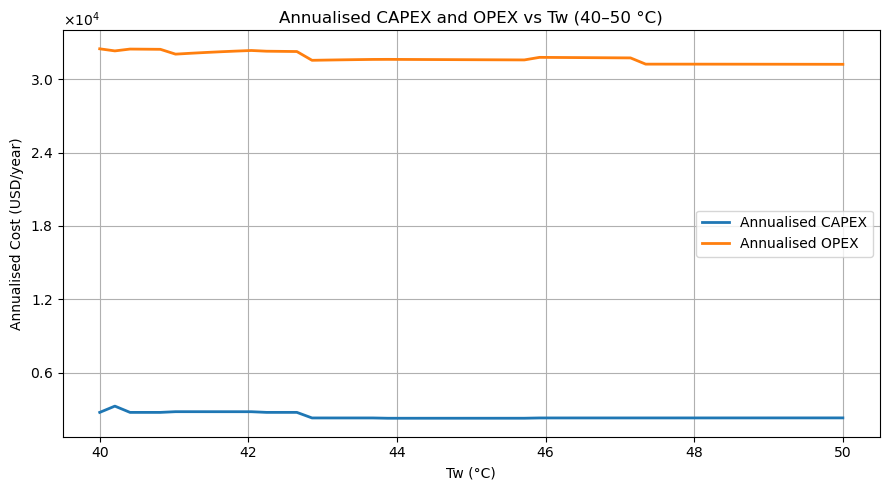

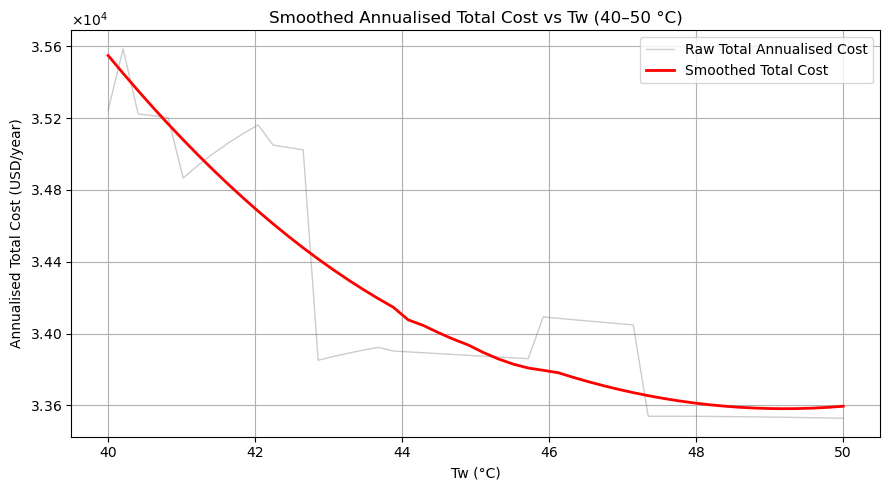

In [ ]:
Tw_min = 40.0
Tw_max = 50.0
num_points = 41     # 0.25°C spacing
years = 5           # annualisation period

Tw_values = np.linspace(Tw_min, Tw_max, num_points)

annual_capex = []
annual_opex  = []
annual_total = []

for Tw in Tw_values:
    capex, opex = get_capex_opex(Tw)
    annual_capex.append(capex / years)
    annual_opex.append(opex / years)
    annual_total.append((capex + opex) / years)

annual_capex = np.array(annual_capex)
annual_opex  = np.array(annual_opex)
annual_total = np.array(annual_total)

# =============================================================
#                FIGURE 1: CAPEX + OPEX vs Tw
# =============================================================
plt.figure(figsize=(9,5))

plt.plot(Tw_values, annual_capex, label="Annualised CAPEX", linewidth=2)
plt.plot(Tw_values, annual_opex,  label="Annualised OPEX", linewidth=2)

plt.xlabel("Tw (°C)")
plt.ylabel("Annualised Cost (USD/year)")
plt.title("Annualised CAPEX and OPEX vs Tw (40–50 °C)")
plt.grid(True)
plt.legend()


ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(10)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()


# =============================================================
#                FIGURE 2: TOTAL COST vs Tw
# =============================================================
plt.figure(figsize=(9,5))

# apply Savitzky–Golay smoothing
smooth_total = savgol_filter(annual_total, window_length=40, polyorder=2)

plt.plot(Tw_values, annual_total, label="Raw Total Annualised Cost", color="gray", alpha=0.4, linewidth=1)
plt.plot(Tw_values, smooth_total, label="Smoothed Total Cost", color="red", linewidth=2)

plt.xlabel("Tw (°C)")
plt.ylabel("Annualised Total Cost (USD/year)")
plt.title("Smoothed Annualised Total Cost vs Tw (40–50 °C)")
plt.grid(True)
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(10)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()
